# CTP1 correlation analysis
Purpose: Determine correlative effects between CTP1 and other genes

#### Data sources:
- `refine.bio.yeast.all`: Yeast refine.bio compendium ([link](https://www.refine.bio/search?filter_order=organism%2Ctechnology&organism=SACCHAROMYCES_CEREVISIAE&technology=rna-seq))

#### Table of contents:
<ul>
    <li><a href="#import">Part 0: Import dependencies & custom functions</a></li>
    <li><a href="#genelists">Part 1: Read in gene lists for analysis</a></li>
    <li><a href="#refine">Part 2: refine.bio yeast data analysis</a></li>
    <ul>
        <li>1. Extract datatables from studies</li>
        <li>2. Parse wild-type samples</li>
        <li>3. Read SpQN-corrected wild-type data</li>
        <li>4. Parse and visualize correlated genes with CTP1 from wild-type yeast datasets</li>
        <li>5. Read SpQN-corrected all yeast data</li>
        <li>6. Parse and visualize correlated genes with CTP1 from all yeast datasets</li>
        <li>7. GO enrichment of refine.bio wild-type strains</li>
        <li>8. GO enrichment of all refine.bio strains</li>
    </ul>
    <li><a href="#session">Part 3: Print session info</a></li>
    
</ul>




<a id="import"><h3>Part 0: Import dependencies & custom functions</h3></a>

In [4]:
import os
import sys
import ast

import json
import scipy
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.readwrite import json_graph

sns.set(font='arial')
sns.set(font_scale=float(.1))
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

from py_funcs import \
    read_table, \
    parse_genelist, \
    g_decompress, \
    make_gene_dict, \
    get_quantiles, \
    read_corr_data, \
    get_graph, \
    output_graph, \
    read_graph, \
    make_subgraph, \
    make_hist_gene, \
    make_clustermap

from combat import combat

__path__ = os.getcwd()

%matplotlib inline

In [5]:
_seed = 4000
random.seed(_seed)

<a id="genelists"><h3>Part 1: Read in custom gene lists for analysis</h3></a>

In [6]:
query_name = 'CTP1'
query_id = 'YBR291C'

query_name2 = 'MCT1'
query_id2 = 'YOR221C'

custom_list = {
    query_name: query_id,
    query_name2: query_id2,
    "Mae1": "YKL029C",
    "Pyc1": "YGL062W",
    "Pyc2": "YBR218C",
    "Cit2": "YCR005C",
    "Cit3": "YPR001W",
    "GDH1": "GDH1",
    "Gdh2": "YDL215C",
    "DLD1": "DLD1",
    "DLD3": "DLD3",
}

In [36]:
print('Making gene dict')
gene_dict = make_gene_dict(__path__)

Making gene dict


E:\projects\Metaboverse-manuscript\mct1_analysis\notebooks\py_funcs.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes['original'] = gtf.loc[gtf[2] == 'gene'][8].str.split("gene_id \"").str[1].str.split("\"; ").str[0].tolist()
E:\projects\Metaboverse-manuscript\mct1_analysis\notebooks\py_funcs.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes['new'] = gtf.loc[gtf[2] == 'gene'][8].str.split("gene_name \"").str[1].str.split("\"; ").str[0].tolist()


In [37]:
gene_dict

{'YDL248W': 'COS7',
 'YDL247W-A': 'YDL247W-A',
 'YDL247W': 'MPH2',
 'YDL246C': 'SOR2',
 'YDL245C': 'HXT15',
 'YDL244W': 'THI13',
 'YDL243C': 'AAD4',
 'YDL242W': 'YDL242W',
 'YDL241W': 'YDL241W',
 'YDL240C-A': 'YDL240C-A',
 'YDL240W': 'LRG1',
 'YDL239C': 'ADY3',
 'YDL238C': 'GUD1',
 'YDL237W': 'AIM6',
 'YDL236W': 'PHO13',
 'YDL235C': 'YPD1',
 'YDL234C': 'GYP7',
 'YDL233W': 'MFG1',
 'YDL232W': 'OST4',
 'YDL231C': 'BRE4',
 'YDL230W': 'PTP1',
 'YDL229W': 'SSB1',
 'YDL228C': 'YDL228C',
 'YDL227C': 'HO',
 'YDL226C': 'GCS1',
 'YDL225W': 'SHS1',
 'YDL224C': 'WHI4',
 'YDL223C': 'HBT1',
 'YDL222C': 'FMP45',
 'YDL221W': 'YDL221W',
 'YDL220C': 'CDC13',
 'YDL219W': 'DTD1',
 'YDL218W': 'YDL218W',
 'YDL217C': 'TIM22',
 'YDL216C': 'RRI1',
 'YDL215C': 'GDH2',
 'YDL214C': 'PRR2',
 'YDL213C': 'NOP6',
 'YDL212W': 'SHR3',
 'YDL211C': 'YDL211C',
 'tG(GCC)D1': 'tG(GCC)D1',
 'YDL210W': 'UGA4',
 'YDL209C': 'CWC2',
 'YDL208W': 'NHP2',
 'YDL207W': 'GLE1',
 'YDL206W': 'YDL206W',
 'YDL205C': 'HEM3',
 'YDL204W': 'R

<a id="refine"><h3>Part 2: refine.bio yeast data analysis</h3></a>

**1. Extract datatables from studies**

In [38]:
refine_path = os.path.join(
    __path__,
    "..",
    "data",
    "refine.bio.yeast.all")
with open(
        os.path.join(refine_path, 'aggregated_metadata.json'), 'r') as jsonfile:
    metadata = json.load(jsonfile)

In [39]:
tables = []
for k in metadata['experiments'].keys():
    file = os.path.join(refine_path, k, k + ".tsv")
    data = pd.read_csv(
        file,
        sep='\t',
        index_col=0
    )
    data.index.name = None
    tables.append(data)
agg_data = pd.concat(tables, axis=1)

agg_data.to_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        "refine_bio_all.tsv"), 
    sep="\t")

print("Data dimensions:", agg_data.shape)

Data dimensions: (6752, 6370)


**2. Parse wild-type samples**

In [40]:
# WT strains cross-referenced with SGD, GEO, and EBI
include_terms = [
    'by4716',
    'by4741',
    'by4741 wild type',
    'by4742',
    'by4743',
    'cbs7960',
    'clib215',
    'clib324',
    'ec1118',
    'pw5',
    's288c',
    'sk1',
    'sls045 (diploid, s288c background)',
    't7',
    't73',
    'w303',
    'w303 wild-type',
    'w303a',
    'wide type',
    'wild-type',
    'wildtype',
    'wt',
    'wt by4742 (mata his3-delta-1 leu2-delta-0 lys2-delta-0 ura3-delta-0)',
    'ztw1, a wild type strain'
]

s = []

for k,v in metadata["samples"].items():
    if v["refinebio_cell_line"] in include_terms:
        s.append(k)
        
print(len(s), "wild-type samples found")

agg_data_wt = agg_data[s]
print("Data dimensions:", agg_data_wt.shape)

agg_data_wt.to_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        "refine_bio_wt.tsv"), 
    sep="\t")

1248 wild-type samples found
Data dimensions: (6752, 1248)


**3. Read SpQN-corrected wild-type data**

In [55]:
file_name = "refine_bio_wt_spqn_cor.tsv"

data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        file_name), 
    sep='\t'
)

**4. Parse and visualize correlated genes with CTP1 from wild-type yeast datasets**

In [9]:
ctp1_list = data.loc["YBR291C"].loc[data.loc["YBR291C"] > 0.5].sort_values(ascending=False)
print(len(ctp1_list.index.tolist()), "genes\n")
for x in ctp1_list.index.tolist():
    print(gene_dict[x])

19 genes

CTP1
LYS4
ARG8
ACO2
MET17
PFA5
YIL165C
RTC2
LYS9
YCT1
MET2
SUL1
RFT1
YLL020C
PEX2
PUT4
YKE4
YIL100W
AGX1


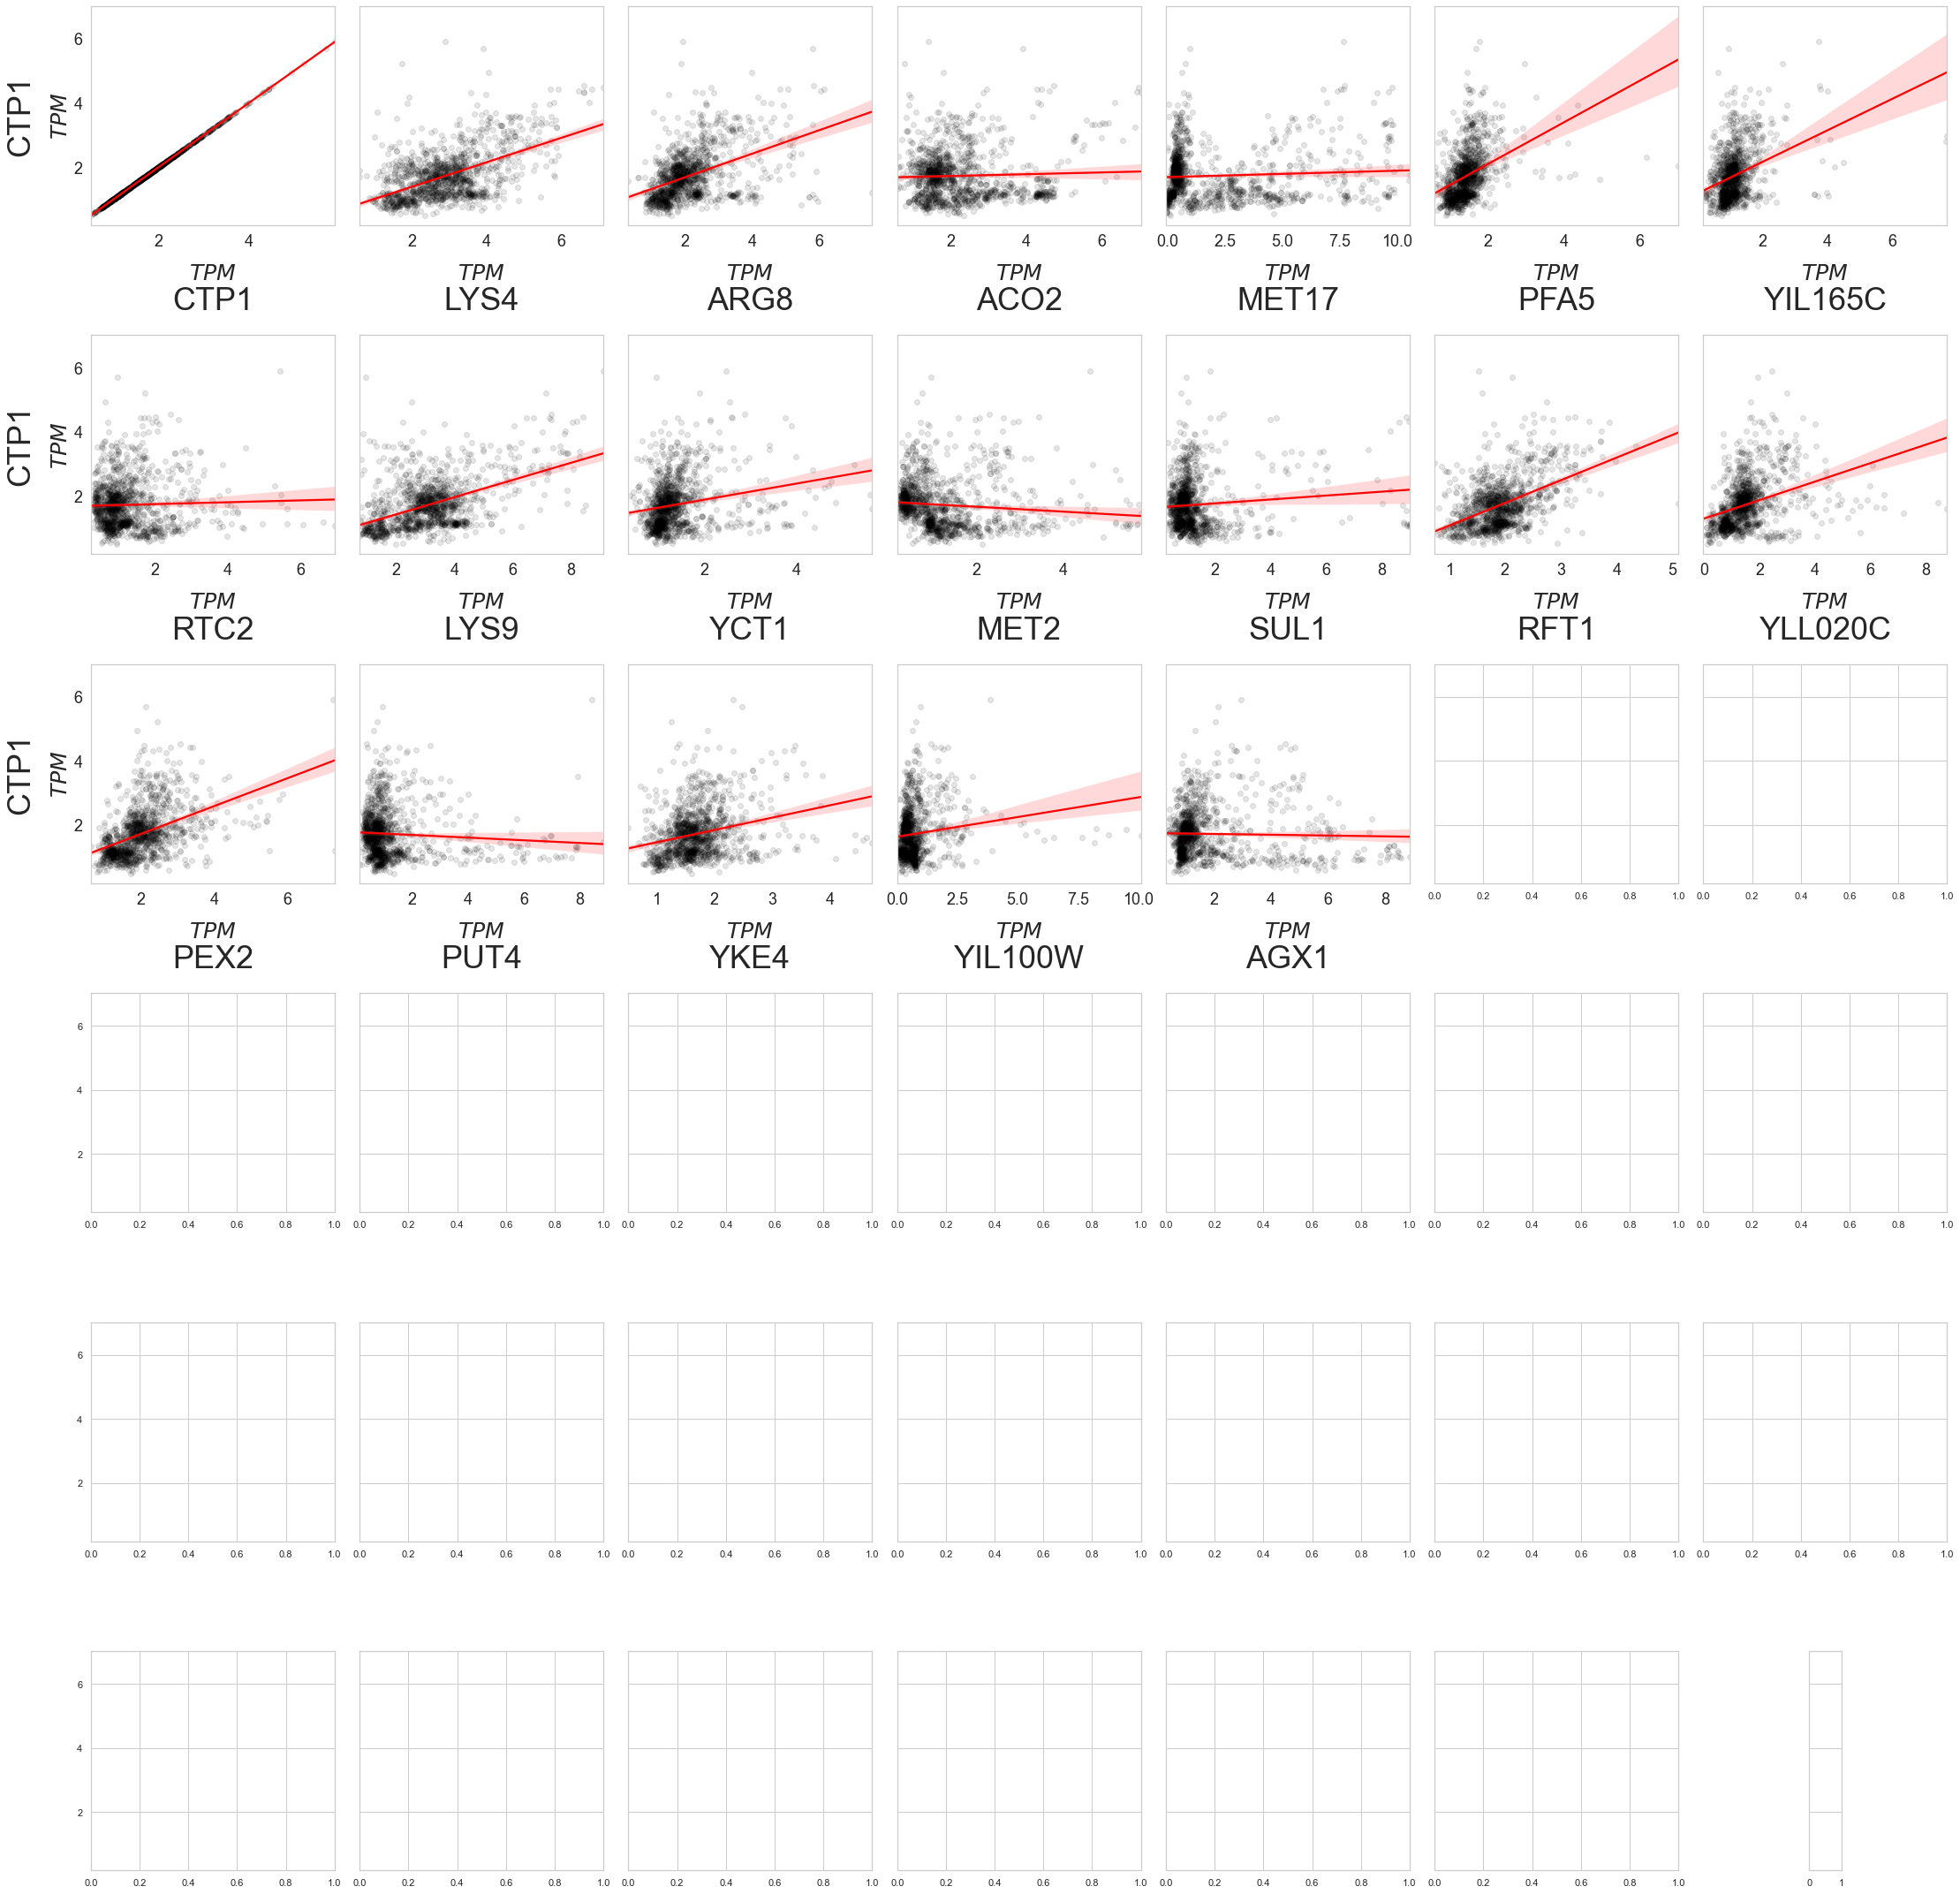

In [10]:
x_plots = 6
y_plots = 7
_figsize = (30,30)

sns.set(font='arial')
sns.set_style("whitegrid")

f, axes = plt.subplots(x_plots, y_plots, figsize=_figsize, sharey=True)
plt.gca().set_aspect('equal')
f.tight_layout()

plt.subplots_adjust(hspace = 0.5)

counter = 0
y_counter = 0
for k in ctp1_list.index.tolist()[0:47]:
    sns.regplot(
        x=agg_data_wt.T[k], 
        y=agg_data_wt.T["YBR291C"], 
        seed=_seed, 
        ax=axes[y_counter, counter], 
        scatter_kws={'alpha': 0.1, 'color': 'black'},
        line_kws={"color": "red"}
    )
    
    
    #agg_data_wt.T.plot.hexbin(
    #    x=k, 
    #    y="YBR291C", 
    #    gridsize=30, 
    #    ax=axes[y_counter, counter], 
    #    cmap="inferno")

    if counter == 0:
        axes[y_counter, counter].set_ylabel("CTP1\n$_{TPM}$", fontsize = 36) # Y label
    else:
        axes[y_counter, counter].set_ylabel("", fontsize = 20) # Y label
    axes[y_counter, counter].set_xlabel("$_{TPM}$\n" + gene_dict[k], fontsize = 36) # X label
    
    axes[y_counter, counter].tick_params(axis='both', which='major', labelsize=18)
    axes[y_counter, counter].tick_params(axis='both', which='minor', labelsize=18)
    axes[y_counter, counter].grid(False)
    
    counter += 1
    
    if counter == y_plots:
        counter = 0 
        y_counter += 1
        
f.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_coexpression_hits_wt.png"),
    dpi=600,
    bbox_inches="tight")

**5. Read SpQN-corrected all yeast data**

In [11]:
file_name = "refine_bio_all_spqn_cor.tsv"

data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        file_name), 
    sep='\t'
)

**6. Parse and visualize correlated genes with CTP1 from all yeast datasets**

In [12]:
ctp1_list = data.loc["YBR291C"].loc[data.loc["YBR291C"] > 0.5].sort_values(ascending=False)
print(len(ctp1_list.index.tolist()), "genes\n")
for x in ctp1_list.index.tolist():
    print(gene_dict[x])

44 genes

CTP1
LYS9
LYS12
LYS4
ACO2
LYS1
CPA1
LYS21
YHM2
SUL1
MET5
LYS20
RTC2
ANS1
MET2
ARG3
PEX21
MET10
MET3
SUL2
LEU2
MET14
GRX8
ADE5,7
YLR302C
PEX11
ARG5,6
MEP2
MET13
STR3
MET1
MET16
HPT1
JJJ3
DAL3
YKR033C
LYS2
LYS14
CPA2
ARG8
MET17
PPH3
ODC2
SAM1


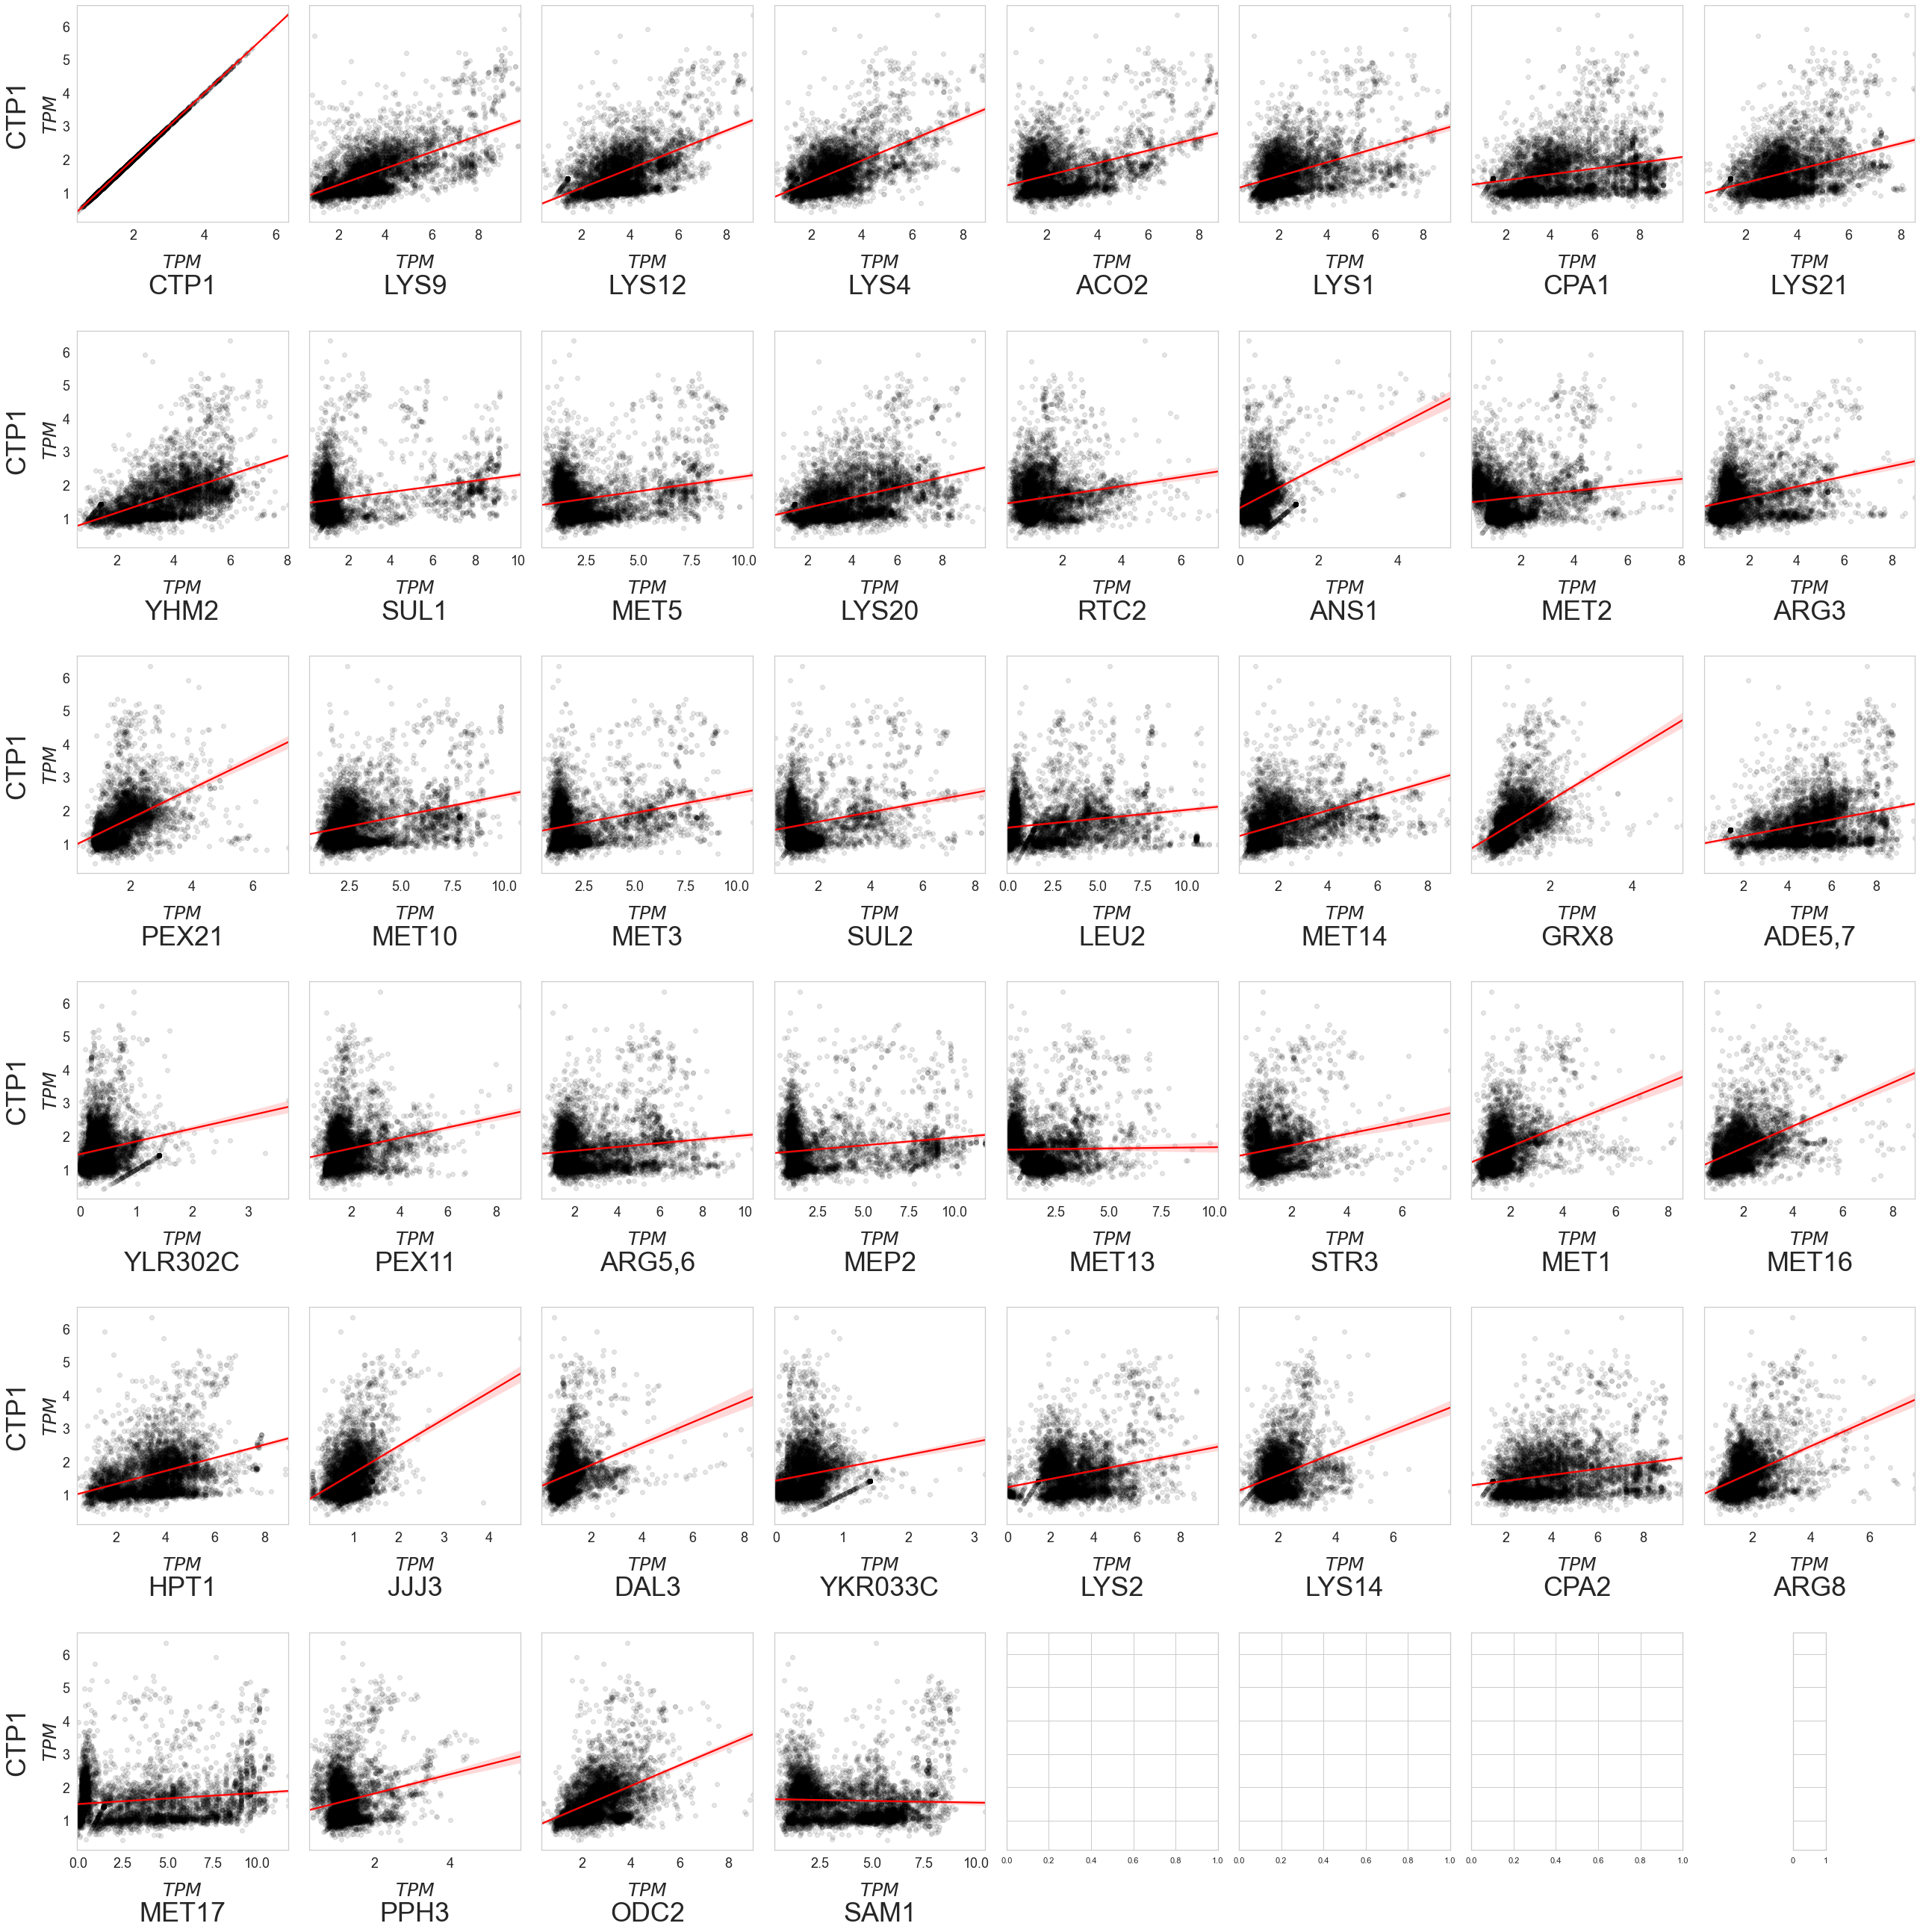

In [13]:
x_plots = 6
y_plots = 8
_figsize = (35,35)

sns.set(font='arial')
sns.set_style("whitegrid")

f, axes = plt.subplots(x_plots, y_plots, figsize=_figsize, sharey=True)
plt.gca().set_aspect('equal')
f.tight_layout()

plt.subplots_adjust(hspace = 0.5)

counter = 0
y_counter = 0
for k in ctp1_list.index.tolist()[0:47]:
    sns.regplot(
        x=agg_data.T[k], 
        y=agg_data.T["YBR291C"], 
        seed=_seed, 
        ax=axes[y_counter, counter], 
        scatter_kws={'alpha': 0.1, 'color': 'black'},
        line_kws={"color": "red"})
     
    if counter == 0:
        axes[y_counter, counter].set_ylabel("CTP1\n$_{TPM}$", fontsize = 36) # Y label
    else:
        axes[y_counter, counter].set_ylabel("", fontsize = 20) # Y label
    axes[y_counter, counter].set_xlabel("$_{TPM}$\n" + gene_dict[k], fontsize = 36) # X label
    
    axes[y_counter, counter].tick_params(axis='both', which='major', labelsize=18)
    axes[y_counter, counter].tick_params(axis='both', which='minor', labelsize=18)
    axes[y_counter, counter].grid(False)
    
    counter += 1
    
    if counter == y_plots:
        counter = 0 
        y_counter += 1

f.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_coexpression_hits_all.png"),
    dpi=600,
    bbox_inches="tight")


**7. GO enrichment of refine.bio wild-type strains**

In [14]:
ctp1_go = "analysis-ctp1-wt.txt"

ctp1_go_data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        ctp1_go),
    sep="\t",
    skiprows=11)


In [15]:
# Manually remove redundant GO terms

In [16]:
ctp1_go_data['GO biological process complete'].tolist()

['lysine biosynthetic process via aminoadipic acid (GO:0019878)',
 'lysine biosynthetic process (GO:0009085)',
 'lysine metabolic process (GO:0006553)',
 'aspartate family amino acid biosynthetic process (GO:0009067)',
 'serine family amino acid metabolic process (GO:0009069)',
 'aspartate family amino acid metabolic process (GO:0009066)',
 'alpha-amino acid biosynthetic process (GO:1901607)',
 'carboxylic acid transmembrane transport (GO:1905039)',
 'organic acid transmembrane transport (GO:1903825)',
 'cellular amino acid biosynthetic process (GO:0008652)',
 'organic acid transport (GO:0015849)',
 'alpha-amino acid metabolic process (GO:1901605)',
 'carboxylic acid biosynthetic process (GO:0046394)',
 'organic acid biosynthetic process (GO:0016053)',
 'cellular amino acid metabolic process (GO:0006520)',
 'small molecule biosynthetic process (GO:0044283)',
 'carboxylic acid metabolic process (GO:0019752)',
 'oxoacid metabolic process (GO:0043436)',
 'organic acid metabolic process (G

In [17]:
this_list = [
    'lysine biosynthetic process via aminoadipic acid (GO:0019878)',
    'aspartate family amino acid biosynthetic process (GO:0009067)',
    'serine family amino acid metabolic process (GO:0009069)',
    'alpha-amino acid biosynthetic process (GO:1901607)',
    'carboxylic acid transmembrane transport (GO:1905039)',
    'carboxylic acid biosynthetic process (GO:0046394)',
    'small molecule biosynthetic process (GO:0044283)',
    'oxoacid metabolic process (GO:0043436)'
]

In [18]:
ctp1_go_data = ctp1_go_data.loc[ctp1_go_data['GO biological process complete'].isin(this_list)]
ctp1_go_data = ctp1_go_data[["GO biological process complete", "upload_1 (fold Enrichment)", "upload_1 (FDR)"]]

fold_sym = r'Fold Change'
abs_sym = r'| Fold Change |'

ctp1_go_data[fold_sym] = ctp1_go_data['upload_1 (fold Enrichment)'] #np.log2(ctp1_go_data['upload_1 (fold Enrichment)'])
ctp1_go_data[abs_sym] = abs(ctp1_go_data[fold_sym])
ctp1_go_data['-log10fdr'] = -1 * np.log10(ctp1_go_data['upload_1 (FDR)'])

ctp1_go_data = ctp1_go_data.sort_values(by="-log10fdr", ascending=False)
ctp1_go_data = ctp1_go_data.reindex(index=ctp1_go_data.index[::-1]).reset_index().drop("index", axis=1)
ctp1_go_data['index'] = ctp1_go_data.index + 1

In [19]:
sns.set_style("whitegrid", {'axes.grid' : False})

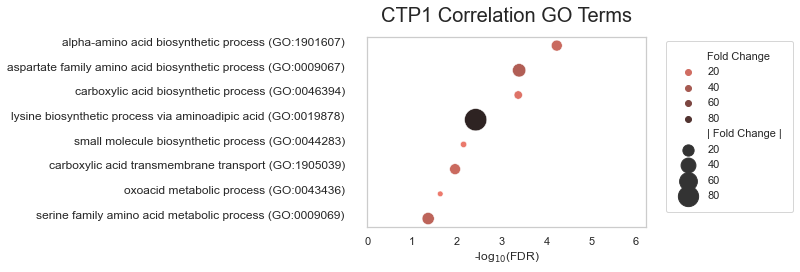

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3.5)
plt.xlim((0,ctp1_go_data["-log10fdr"].max() + 2))

# use the scatterplot function to build the bubble map
sns.scatterplot(
    data=ctp1_go_data.round(decimals=2), 
    x="-log10fdr", 
    y="index", 
    size=abs_sym, 
    hue=fold_sym, 
    legend=True, 
    sizes=(1, 500),
    palette="dark:salmon_r",
    size_norm=(0, ctp1_go_data[abs_sym].max() + 1),
    hue_norm=(0, ctp1_go_data[abs_sym].max()))

ax.set_xlabel("-log$_1$$_0$(FDR)")
ax.set_ylabel("")
ax.get_yaxis().set_ticks([])
ax.set_title("CTP1 Correlation GO Terms", pad=15, fontsize=20)

for index, row in ctp1_go_data.iterrows():
    ax.text(s=row["GO biological process complete"], x=-0.5, y=row["index"], ha='right')

ax.legend(bbox_to_anchor=(1.05, 1.01), borderpad=1)

# show the graph
fig.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_go_enrichment_bubble-wt.svg"),
    bbox_inches="tight")

**8. GO enrichment of all refine.bio strains**

In [21]:
ctp1_go = "analysis-ctp1-all.txt"

ctp1_go_data = pd.read_csv(
    os.path.join(
        __path__,
        "..",
        "data",
        ctp1_go),
    sep="\t",
    skiprows=11)


In [22]:
ctp1_go_data = ctp1_go_data.iloc[0:40]

In [23]:
# Manually remove redundant GO terms

In [24]:
ctp1_go_data['GO biological process complete'].tolist()

['sulfate reduction (GO:0019419)',
 'sulfate assimilation, phosphoadenylyl sulfate reduction by phosphoadenylyl-sulfate reductase (thioredoxin) (GO:0019379)',
 'hydrogen sulfide biosynthetic process (GO:0070814)',
 'hydrogen sulfide metabolic process (GO:0070813)',
 'lysine biosynthetic process via aminoadipic acid (GO:0019878)',
 'mitochondrial citrate transmembrane transport (GO:0006843)',
 'tricarboxylic acid transport (GO:0006842)',
 'citrulline biosynthetic process (GO:0019240)',
 'tricarboxylic acid transmembrane transport (GO:0035674)',
 'sulfate assimilation (GO:0000103)',
 'citrulline metabolic process (GO:0000052)',
 'citrate transport (GO:0015746)',
 'mitochondrial tricarboxylic acid transmembrane transport (GO:1990546)',
 'lysine biosynthetic process (GO:0009085)',
 'lysine metabolic process (GO:0006553)',
 'arginine biosynthetic process (GO:0006526)',
 'cysteine biosynthetic process (GO:0019344)',
 'ornithine metabolic process (GO:0006591)',
 'aspartate family amino acid b

In [25]:
this_list = [
    'mitochondrial citrate transmembrane transport (GO:0006843)',
    'tricarboxylic acid transport (GO:0006842)',
    'citrulline biosynthetic process (GO:0019240)',
    'purine nucleobase metabolic process (GO:0006144)',
    'citrulline metabolic process (GO:0000052)',
    'citrate transport (GO:0015746)',
    'homoserine metabolic process (GO:0009092)',
    'glutamine family amino acid metabolic process (GO:0009064)',
    'ornithine metabolic process (GO:0006591)',
    'serine family amino acid biosynthetic process (GO:0009070)',
    'cysteine metabolic process (GO:0006534)',
    'nucleobase metabolic process (GO:0009112)',
    'sulfate reduction (GO:0019419)',
    'arginine metabolic process (GO:0006525)',
    'methionine biosynthetic process (GO:0009086)',
    'hydrogen sulfide biosynthetic process (GO:0070814)',
    'sulfur amino acid biosynthetic process (GO:0000097)',
    'sulfate assimilation (GO:0000103)',
    'lysine biosynthetic process via aminoadipic acid (GO:0019878)',
    'cellular amino acid metabolic process (GO:0006520)',
    'aspartate family amino acid biosynthetic process (GO:0009067)',
    'carboxylic acid biosynthetic process (GO:0046394)'
]

In [26]:
ctp1_go_data = ctp1_go_data.loc[ctp1_go_data['GO biological process complete'].isin(this_list)]

ctp1_go_data = ctp1_go_data[["GO biological process complete", "upload_1 (fold Enrichment)", "upload_1 (FDR)"]]

fold_sym = r'Fold Change'
abs_sym = r'| Fold Change |'

ctp1_go_data[fold_sym] = ctp1_go_data['upload_1 (fold Enrichment)'] #np.log2(ctp1_go_data['upload_1 (fold Enrichment)'])
ctp1_go_data[abs_sym] = abs(ctp1_go_data[fold_sym])
ctp1_go_data['-log10fdr'] = -1 * np.log10(ctp1_go_data['upload_1 (FDR)'])

ctp1_go_data = ctp1_go_data.sort_values(by="-log10fdr", ascending=False)
ctp1_go_data = ctp1_go_data.reindex(index=ctp1_go_data.index[::-1]).reset_index().drop("index", axis=1)
ctp1_go_data['index'] = ctp1_go_data.index + 1

In [27]:
sns.set_style("whitegrid", {'axes.grid' : False})

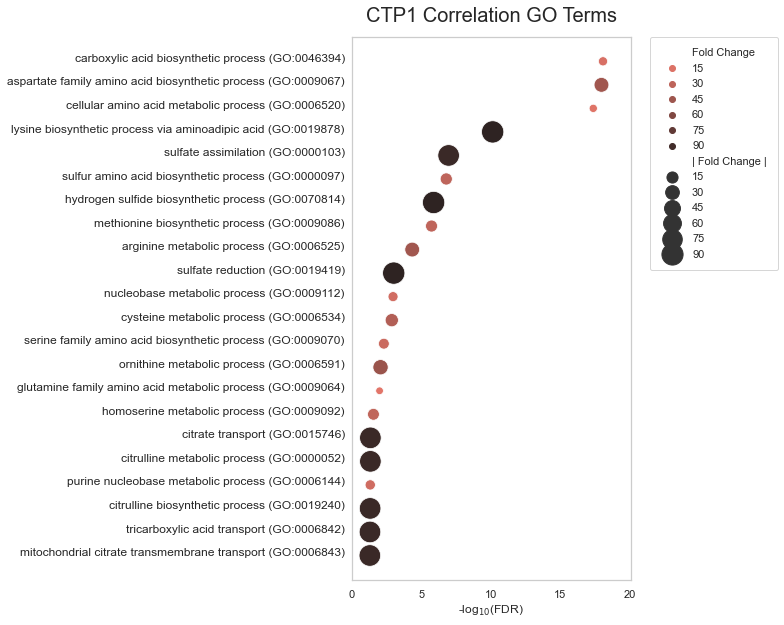

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 10)
plt.xlim((0,ctp1_go_data["-log10fdr"].max() + 2))

# use the scatterplot function to build the bubble map
sns.scatterplot(
    data=ctp1_go_data.round(decimals=2), 
    x="-log10fdr", 
    y="index", 
    size=abs_sym, 
    hue=fold_sym, 
    legend=True, 
    sizes=(1, 500),
    palette="dark:salmon_r",
    size_norm=(0, ctp1_go_data[abs_sym].max() + 1),
    hue_norm=(0, ctp1_go_data[abs_sym].max()))

ax.set_xlabel("-log$_1$$_0$(FDR)")
ax.set_ylabel("")
ax.get_yaxis().set_ticks([])
ax.set_title("CTP1 Correlation GO Terms", pad=15, fontsize=20)

for index, row in ctp1_go_data.iterrows():
    ax.text(s=row["GO biological process complete"], x=-0.5, y=row["index"], ha='right')

ax.legend(bbox_to_anchor=(1.05, 1.01), borderpad=1)

# show the graph
fig.savefig(
    os.path.join(
        __path__,
        "..",
        "data",
        "ctp1_go_enrichment_bubble-all.svg"),
    bbox_inches="tight")

<a id="session"><h3>Part 3: Print session info</h3></a>

In [29]:
!conda list

# packages in environment at C:\Users\jorda\miniconda3:
#
# Name                    Version                   Build  Channel
alabaster                 0.7.12                   pypi_0    pypi
altgraph                  0.17               pyhd8ed1ab_0    conda-forge
anyio                     3.1.0            py39hcbf5309_0    conda-forge
appdirs                   1.4.4                    pypi_0    pypi
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
astroid                   2.4.2            py39hde42818_1    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
autograd                  1.3                        py_0    conda-forge
autopep8                  1.5.4                    pypi_0    pypi
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports           